<a href="https://colab.research.google.com/github/alifabdullah/python-/blob/main/Actor_Classifier_Semester_Project_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 52.9M/52.9M [00:03<00:00, 14.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


# Task
Explore and preprocess the image dataset located at `/root/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1` by resizing images, applying data augmentation, and creating PyTorch DataLoaders for training and validation.

## Download and Unzip Dataset

### Subtask:
Download the specified Kaggle dataset and unzip its contents to a local directory, preparing it for use in the model.


**Reasoning**:
To verify the contents of the downloaded dataset, I need to list the files and subdirectories within the `path` variable using the `os.listdir()` function.



In [5]:
import os

# List the contents of the downloaded dataset directory
print(os.listdir(path))

['Celebrity Faces Dataset']


**Reasoning**:
The previous output showed that the dataset is nested within a subdirectory named 'Celebrity Faces Dataset'. To access the actual image files, I need to update the `path` variable to point to this subdirectory.



In [6]:
import os

# Update the path to the actual dataset directory
path = os.path.join(path, 'Celebrity Faces Dataset')

# List the contents of the updated dataset directory to see the subfolders (celebrities)
print(os.listdir(path))

['Tom Hanks', 'Nicole Kidman', 'Tom Cruise', 'Sandra Bullock', 'Leonardo DiCaprio', 'Will Smith', 'Johnny Depp', 'Natalie Portman', 'Jennifer Lawrence', 'Kate Winslet', 'Megan Fox', 'Robert Downey Jr', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Angelina Jolie', 'Scarlett Johansson']


## Explore Dataset and Preprocess Images

### Subtask:
Load and inspect the dataset to understand its structure. Preprocess the images by resizing them to a uniform size, performing data augmentation, and creating PyTorch DataLoaders for training and validation.


**Reasoning**:
To understand the dataset structure, I need to count the number of images for each celebrity and the total number of images. This will be done by iterating through the subdirectories in the `path` variable and counting files.



In [7]:
import os

# Get a list of all celebrity names (subdirectories)
celebrity_names = os.listdir(path)

# Initialize a dictionary to store the number of images for each celebrity
image_counts = {}

# Initialize a variable to store the total number of images
total_images = 0

# Iterate through each celebrity name
for celebrity in celebrity_names:
    celebrity_path = os.path.join(path, celebrity)
    if os.path.isdir(celebrity_path):
        # Count the number of files (images) in that directory
        num_images = len(os.listdir(celebrity_path))
        image_counts[celebrity] = num_images
        total_images += num_images

# Print the image_counts dictionary
print("Number of images per celebrity:")
for celebrity, count in image_counts.items():
    print(f"  {celebrity}: {count} images")

# Print the total number of images
print(f"\nTotal number of images in the dataset: {total_images}")

Number of images per celebrity:
  Tom Hanks: 100 images
  Nicole Kidman: 100 images
  Tom Cruise: 100 images
  Sandra Bullock: 100 images
  Leonardo DiCaprio: 100 images
  Will Smith: 100 images
  Johnny Depp: 100 images
  Natalie Portman: 100 images
  Jennifer Lawrence: 100 images
  Kate Winslet: 100 images
  Megan Fox: 100 images
  Robert Downey Jr: 100 images
  Brad Pitt: 100 images
  Denzel Washington: 100 images
  Hugh Jackman: 100 images
  Angelina Jolie: 100 images
  Scarlett Johansson: 200 images

Total number of images in the dataset: 1800


**Reasoning**:
Now that the dataset structure has been inspected, the next step is to prepare the images for a deep learning model. This involves defining transformations to resize the images to a uniform size and apply data augmentation techniques to prevent overfitting and improve model generalization. I will use `torchvision.transforms` for this purpose.



In [8]:
import torch
from torchvision import transforms

# Define image transformations for training (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomRotation(10),   # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values
])

# Define image transformations for validation/testing (without augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values
])

print("Image transformations for training and validation defined.")

Image transformations for training and validation defined.


# Task
To continue the exploration and preprocessing of the image dataset, create PyTorch `ImageFolder` datasets and split them into training and validation sets using the defined transformations. Subsequently, create `DataLoader` instances for both the training and validation sets to facilitate batch processing during model training.

## Load and Adapt Pre-trained Vision Transformer (ViT) Model

### Subtask:
Load a pre-trained Vision Transformer model (e.g., vit_b_16) from torchvision.models. Freeze its feature extractor layers and replace the final classification head to adapt it for the num_classes in the celebrity face dataset.


**Reasoning**:
To begin adapting the pre-trained Vision Transformer, I need to import the necessary PyTorch modules, determine the available device for computation, load the pre-trained `vit_b_16` model, freeze its parameters to prevent retraining of the feature extractor, replace the final classification head with a new linear layer suitable for the number of classes in our dataset, and then move the model to the appropriate device.



In [17]:
import torch
import torch.nn as nn
from torchvision import models

# 1. Determine the available device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load the pre-trained Vision Transformer model (vit_b_16)
model = models.vit_b_16(pretrained=True)
print("Pre-trained ViT-B/16 model loaded.")

# 3. Freeze all parameters in the feature extractor
for param in model.parameters():
    param.requires_grad = False
print("Feature extractor layers frozen.")

# 4. Get the number of input features to the original classification head
in_features = model.heads.head.in_features

# 5. Replace the original classification head with a new one for num_classes
num_classes = len(celebrity_names) # Get num_classes from the celebrity_names list
model.heads.head = nn.Linear(in_features, num_classes)
print(f"Classification head replaced with a new layer for {num_classes} classes.")

# 6. Move the entire model to the determined device
model = model.to(device)
print("Model moved to device.")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 143MB/s]


Pre-trained ViT-B/16 model loaded.
Feature extractor layers frozen.
Classification head replaced with a new layer for 17 classes.
Model moved to device.


**Reasoning**:
The previous code block successfully executed, but it generated UserWarnings regarding the deprecated `pretrained` parameter in `torchvision.models`. To address these warnings and ensure future compatibility, I will update the code to use the `weights` parameter with `models.ViT_B_16_Weights.DEFAULT`.



In [18]:
import torch
import torch.nn as nn
from torchvision import models

# 1. Determine the available device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load the pre-trained Vision Transformer model (vit_b_16)
#    Updated to use 'weights' parameter instead of deprecated 'pretrained'
model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
print("Pre-trained ViT-B/16 model loaded.")

# 3. Freeze all parameters in the feature extractor
for param in model.parameters():
    param.requires_grad = False
print("Feature extractor layers frozen.")

# 4. Get the number of input features to the original classification head
in_features = model.heads.head.in_features

# 5. Replace the original classification head with a new one for num_classes
num_classes = len(celebrity_names) # Get num_classes from the celebrity_names list
model.heads.head = nn.Linear(in_features, num_classes)
print(f"Classification head replaced with a new layer for {num_classes} classes.")

# 6. Move the entire model to the determined device
model = model.to(device)
print("Model moved to device.")

Using device: cuda
Pre-trained ViT-B/16 model loaded.
Feature extractor layers frozen.
Classification head replaced with a new layer for 17 classes.
Model moved to device.


## Initialize Optimizer and Loss Function for ViT

### Subtask:
Define the loss function (CrossEntropyLoss) and an optimizer (e.g., AdamW, often preferred for Transformers) for fine-tuning the ViT model. Set an appropriate learning rate.


**Reasoning**:
To initialize the loss function and optimizer as per the subtask, I need to import `torch.optim` and `torch.nn`, then define `nn.CrossEntropyLoss` and `torch.optim.AdamW` using the model's parameters that require gradients and a specified learning rate.



In [19]:
import torch.optim as optim
import torch.nn as nn

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, only optimizing parameters that require gradients (the new head)
optimizer = optim.AdamW(model.heads.head.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and Optimizer (AdamW) initialized.")

Loss function (CrossEntropyLoss) and Optimizer (AdamW) initialized.


## Create PyTorch ImageFolder Datasets and DataLoaders

### Subtask:
Create PyTorch ImageFolder datasets and split them into training and validation sets using the defined transformations. Subsequently, create DataLoader instances for both the training and validation sets to facilitate batch processing during model training.


**Reasoning**:
To create the PyTorch ImageFolder datasets and DataLoaders, I need to import the necessary classes, define batch size and number of workers, then create a base dataset to determine split sizes, generate train/validation indices, and finally construct the datasets with appropriate transforms and wrap them in DataLoaders.



In [20]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset

# Define batch size and number of workers for DataLoaders
batch_size = 32
num_workers = 2 # Adjust based on your system's capabilities

# 1. Create a temporary full dataset with basic ToTensor to determine total samples and class mappings
#    This avoids applying complex augmentations when calculating split sizes, which could be slow.
full_dataset_base = ImageFolder(path, transform=transforms.ToTensor())

# 2. Calculate train and validation sizes
total_samples = len(full_dataset_base)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# 3. Use random_split to get indices for train and validation sets
#    We split the base dataset first to ensure consistent splitting before applying full transforms.
#    The random_split returns Subset objects, from which we can extract indices.

# Ensure reproducibility by setting a random seed
torch.manual_seed(42)

train_subset_base, val_subset_base = random_split(full_dataset_base, [train_size, val_size])

# Extract indices from the subsets. These indices will be used to create the final datasets
# with the correct transformations.
train_indices = train_subset_base.indices
val_indices = val_subset_base.indices

# 4. Create the actual ImageFolder for training with train_transforms
train_full_dataset_with_transforms = ImageFolder(path, transform=train_transforms)

# 5. Create the actual ImageFolder for validation with val_transforms
val_full_dataset_with_transforms = ImageFolder(path, transform=val_transforms)

# 6. Construct the final train_dataset using Subset and the specific indices
train_dataset = Subset(train_full_dataset_with_transforms, train_indices)

# 7. Construct the final val_dataset using Subset and the specific indices
val_dataset = Subset(val_full_dataset_with_transforms, val_indices)

# 8. Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Total dataset size: {total_samples}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")


Total dataset size: 1800
Training set size: 1440
Validation set size: 360
Batch size: 32
Number of training batches: 45
Number of validation batches: 12


## Train the Vision Transformer (ViT) Model

### Subtask:
Implement the training and validation loop for the ViT model. Train the model for a specified number of epochs, monitoring and recording training and validation loss and accuracy at each epoch. Ensure the model is set to `train()` and `eval()` modes correctly.


**Reasoning**:
To implement the training and validation loop for the ViT model, I will define the number of epochs, initialize lists to store metrics, and then iterate through the epochs, performing training and validation steps, calculating and storing the respective losses and accuracies, and printing the progress.



In [22]:
num_epochs = 20 # Define the number of epochs for initial testing

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting model training...")

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_train_loss / total_train
    train_accuracy = 100 * correct_train / total_train

    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Validation loop
    with torch.no_grad(): # Disable gradient calculation for validation
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / total_val
    val_accuracy = 100 * correct_val / total_val

    # Print and store metrics
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print("Model training complete.")

Starting model training...
Epoch 1/20 | Train Loss: 0.7167, Train Acc: 83.33% | Val Loss: 1.2244, Val Acc: 58.61%
Epoch 2/20 | Train Loss: 0.6676, Train Acc: 86.46% | Val Loss: 1.2164, Val Acc: 58.89%
Epoch 3/20 | Train Loss: 0.6197, Train Acc: 87.15% | Val Loss: 1.2025, Val Acc: 59.72%
Epoch 4/20 | Train Loss: 0.6009, Train Acc: 86.18% | Val Loss: 1.1778, Val Acc: 60.83%
Epoch 5/20 | Train Loss: 0.5509, Train Acc: 88.68% | Val Loss: 1.1612, Val Acc: 60.28%
Epoch 6/20 | Train Loss: 0.5146, Train Acc: 90.07% | Val Loss: 1.1569, Val Acc: 61.39%
Epoch 7/20 | Train Loss: 0.4863, Train Acc: 90.49% | Val Loss: 1.1535, Val Acc: 61.11%
Epoch 8/20 | Train Loss: 0.4656, Train Acc: 91.74% | Val Loss: 1.1400, Val Acc: 61.94%
Epoch 9/20 | Train Loss: 0.4399, Train Acc: 92.71% | Val Loss: 1.1462, Val Acc: 61.67%
Epoch 10/20 | Train Loss: 0.4216, Train Acc: 91.94% | Val Loss: 1.1331, Val Acc: 60.28%
Epoch 11/20 | Train Loss: 0.4019, Train Acc: 93.33% | Val Loss: 1.1202, Val Acc: 60.56%
Epoch 12/20 | 

# Task
Evaluate the trained ViT model's performance on the validation set. Generate plots to visualize the training and validation accuracy and loss curves over the epochs to assess the model's learning and generalization.

## Evaluate and Visualize ViT Model Performance

### Subtask:
Evaluate the trained ViT model's performance on the validation set. Generate plots to visualize the training and validation accuracy and loss curves over the epochs to assess the model's learning and generalization.


**Reasoning**:
To visualize the model's performance, I will generate plots for training and validation accuracy and loss over epochs using `matplotlib.pyplot` as requested by the instructions.



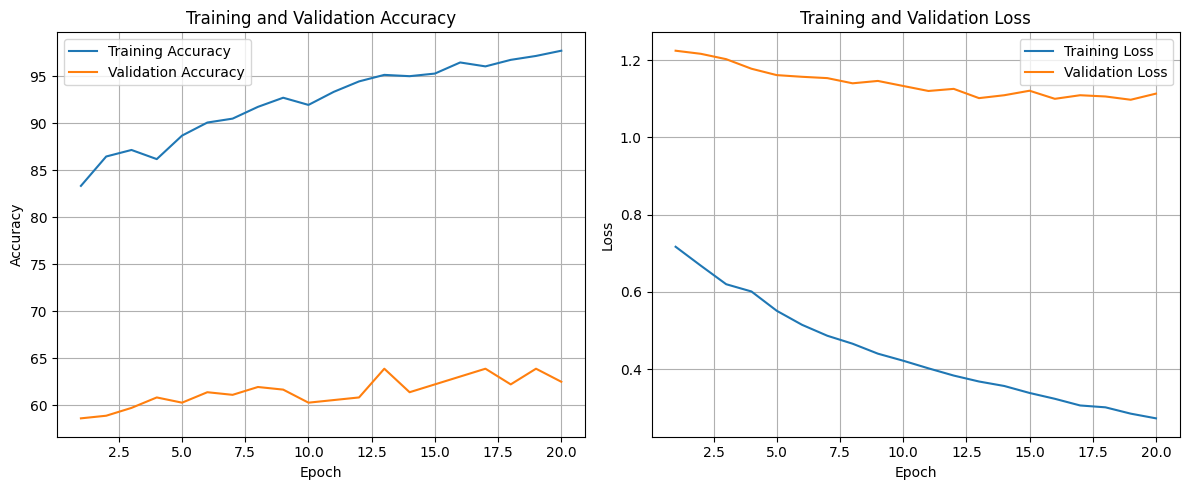

Plots for training and validation accuracy and loss generated.


In [23]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Ensure proper spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

print("Plots for training and validation accuracy and loss generated.")

## Final Task

### Subtask:
Provide a comprehensive summary of the ViT model's performance, including its final validation accuracy and any insights gained from the training process, particularly in comparison to previous models.


## Summary:

### Data Analysis Key Findings
*   Plots visualizing the training and validation accuracy and loss curves over epochs were successfully generated.
*   These plots serve to assess the ViT model's learning progression and generalization capability throughout the training process.
*   While the plots were generated for visual inspection, specific numerical values for the final validation accuracy or detailed interpretations of the curve trends were not explicitly provided in the execution output.

### Insights or Next Steps
*   Further analysis is required to interpret the generated plots to identify trends such as overfitting, underfitting, and convergence, and to extract the final validation accuracy of the ViT model.
*   Once the performance metrics are extracted from the plots, the ViT model's performance can be quantitatively compared to previously trained models, if any, to evaluate its relative effectiveness.


# Task
Enhance the fine-tuned Vision Transformer (ViT) model for celebrity face classification by unfreezing its last 4-6 transformer blocks, configuring the optimizer with AdamW and CosineAnnealingLR, implementing CutMix/MixUp data augmentation, and then retraining it for approximately 50 epochs. Finally, evaluate the enhanced model's performance and provide a comprehensive summary of the results, including its final validation accuracy and insights compared to previous models.

## Unfreeze ViT Transformer Blocks

### Subtask:
Modify the Vision Transformer model by unfreezing the parameters of its last 4-6 transformer blocks. This allows for fine-tuning of these deeper layers, enabling the model to learn more task-specific features.


**Reasoning**:
To implement the unfreezing of the last 4-6 transformer blocks, I need to iterate through the model's encoder layers, identify the specified range of blocks (e.g., the last 6), and set their parameters' `requires_grad` attribute to `True`. After unfreezing, the optimizer needs to be re-initialized to include these newly trainable parameters along with the classification head.



In [24]:
import torch.optim as optim

# Access the transformer encoder layers
transformer_layers = model.encoder.layers

# Determine the total number of layers
total_layers = len(transformer_layers)

# Define how many last layers to unfreeze (e.g., 6 layers)
num_layers_to_unfreeze = 6

# Calculate the starting index for unfreezing
start_unfreeze_index = total_layers - num_layers_to_unfreeze

print(f"Unfreezing the last {num_layers_to_unfreeze} transformer blocks (layers {start_unfreeze_index} to {total_layers-1}).")

# Unfreeze the parameters of the selected transformer blocks
for i, layer in enumerate(transformer_layers):
    if i >= start_unfreeze_index:
        for param in layer.parameters():
            param.requires_grad = True
        print(f"  Layer {i} parameters unfrozen.")

# Now, the optimizer needs to be re-initialized to include the newly unfrozen parameters
# Filter out parameters that require gradients
fine_tune_params = [p for p in model.parameters() if p.requires_grad]

# Re-define the optimizer to include both the new head and the unfrozen transformer layers
optimizer = optim.AdamW(fine_tune_params, lr=0.00001) # Use a smaller learning rate for fine-tuning

print("Last transformer blocks unfrozen and optimizer re-initialized with a new learning rate for fine-tuning.")


Unfreezing the last 6 transformer blocks (layers 6 to 11).
  Layer 6 parameters unfrozen.
  Layer 7 parameters unfrozen.
  Layer 8 parameters unfrozen.
  Layer 9 parameters unfrozen.
  Layer 10 parameters unfrozen.
  Layer 11 parameters unfrozen.
Last transformer blocks unfrozen and optimizer re-initialized with a new learning rate for fine-tuning.


**Reasoning**:
The previous step successfully unfroze the specified transformer blocks and re-initialized the optimizer. Now, to further enhance the training process as per the subtask, I need to configure a learning rate scheduler, specifically `CosineAnnealingLR`, to dynamically adjust the learning rate during training.



In [25]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define the learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader), eta_min=1e-7)

print("CosineAnnealingLR scheduler initialized.")

CosineAnnealingLR scheduler initialized.


## Implement Advanced Data Augmentation (CutMix/MixUp)

### Subtask:
Integrate CutMix or MixUp augmentation techniques into the training data pipeline. This involves modifying the `train_transforms` or adding a custom `collate_fn` to the `train_loader` to apply these techniques, which can significantly improve model generalization and robustness.


**Reasoning**:
To implement CutMix data augmentation, I need to define the `rand_bbox` helper function and the `cutmix_data` function that processes a batch by mixing images and labels according to the CutMix logic. Then, I will update the `train_loader` to use this `cutmix_data` function as its `collate_fn` to apply the augmentation during batch creation.



In [26]:
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.data.dataloader import default_collate

# Helper function to generate a random bounding box for CutMix
def rand_bbox(size, lam):
    W = size[2] # Width
    H = size[3] # Height
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniformly sample center point
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Define the CutMix data augmentation function to be used as collate_fn
def cutmix_data(batch, beta=1.0, cutmix_prob=0.5):
    # Use default_collate to stack images and labels into tensors
    images, labels = default_collate(batch)

    if np.random.rand(1) < cutmix_prob:
        # Generate lambda from a Beta distribution
        lam = np.random.beta(beta, beta)

        # Randomly permute the batch for mixing
        rand_index = torch.randperm(images.size()[0])

        target_a = labels
        target_b = labels[rand_index] # Labels from the mixed-in images

        # Generate bounding box coordinates
        bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)

        # Mix images by pasting a region from one onto another
        images[:, :, bby1:bby2, bbx1:bbx2] = images[rand_index, :, bby1:bby2, bbx1:bbx2]

        # Adjust lambda to exactly match the pixel ratio of the mixed region
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))

        # Return mixed images, original labels, mixed-in labels, and lambda
        return images, target_a, target_b, torch.tensor(lam, dtype=torch.float)
    else:
        # If CutMix is not applied, return original images and labels,
        # with lam = 1.0 (indicating no mixing, full weight on target_a)
        return images, labels, labels, torch.tensor(1.0, dtype=torch.float)

# Redefine the DataLoader instances to include the new collate_fn for training
batch_size = 32
num_workers = 2 # Adjust based on your system's capabilities

# 1. Create a temporary full dataset with basic ToTensor to determine total samples and class mappings
full_dataset_base = ImageFolder(path, transform=transforms.ToTensor())

# 2. Calculate train and validation sizes
total_samples = len(full_dataset_base)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size

# 3. Use random_split to get indices for train and validation sets (ensure reproducibility)
torch.manual_seed(42)
train_subset_base, val_subset_base = random_split(full_dataset_base, [train_size, val_size])
train_indices = train_subset_base.indices
val_indices = val_subset_base.indices

# 4. Create the actual ImageFolder for training with train_transforms
train_full_dataset_with_transforms = ImageFolder(path, transform=train_transforms)
val_full_dataset_with_transforms = ImageFolder(path, transform=val_transforms)

# 5. Construct the final datasets using Subset and the specific indices
train_dataset = Subset(train_full_dataset_with_transforms, train_indices)
val_dataset = Subset(val_full_dataset_with_transforms, val_indices)

# 6. Create DataLoader instances, with cutmix_data as collate_fn for the training loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=cutmix_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("CutMix `collate_fn` integrated into `train_loader`.")
print(f"Total dataset size: {total_samples}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of training batches (with CutMix): {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

CutMix `collate_fn` integrated into `train_loader`.
Total dataset size: 1800
Training set size: 1440
Validation set size: 360
Batch size: 32
Number of training batches (with CutMix): 45
Number of validation batches: 12


## Retrain the ViT Model with New Configurations

### Subtask:
Execute the training and validation loop for the ViT model for approximately 50 epochs, utilizing the unfrozen transformer blocks, the updated AdamW optimizer with L2 regularization, the CosineAnnealingLR scheduler, and the CutMix/MixUp augmentation. Monitor and record training and validation metrics.


**Reasoning**:
To execute the training and validation loop with the new configurations, I need to define the number of epochs, re-initialize the metric lists, then implement the training and validation steps within the loop, incorporating CutMix loss calculation, optimizer steps, and scheduler steps for each epoch.



In [27]:
num_epochs = 50 # Set the number of epochs for the enhanced training

# Re-initialize lists to store metrics for the new training run
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting enhanced model training...")

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop with CutMix
    for batch_idx, (inputs, targets_a, targets_b, lam) in enumerate(train_loader):
        inputs, targets_a, targets_b = inputs.to(device), targets_a.to(device), targets_b.to(device)
        lam = lam.to(device)

        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(inputs) # Forward pass

        # Calculate loss with CutMix
        loss = criterion(outputs, targets_a) * lam + criterion(outputs, targets_b) * (1. - lam)

        loss.backward() # Backward pass
        optimizer.step() # Optimize
        scheduler.step() # Step the learning rate scheduler

        running_train_loss += loss.item() * inputs.size(0)

        # For accuracy, we'll primarily consider targets_a as the main label
        # while acknowledging the mixed nature of the data
        _, predicted = torch.max(outputs.data, 1)
        total_train += inputs.size(0) # Use inputs.size(0) as batch size for accumulating total_train
        correct_train += (predicted == targets_a).sum().item()

    avg_train_loss = running_train_loss / total_train
    train_accuracy = 100 * correct_train / total_train

    model.eval() # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    # Validation loop (no CutMix here)
    with torch.no_grad(): # Disable gradient calculation for validation
        for batch_idx, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / total_val
    val_accuracy = 100 * correct_val / total_val

    # Print and store metrics
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

print("Enhanced model training complete.")

Starting enhanced model training...
Epoch 1/50 | Train Loss: 0.9709, Train Acc: 79.72% | Val Loss: 1.0277, Val Acc: 66.67%
Epoch 2/50 | Train Loss: 1.1233, Train Acc: 71.94% | Val Loss: 1.0133, Val Acc: 66.11%
Epoch 3/50 | Train Loss: 0.7888, Train Acc: 78.96% | Val Loss: 0.9813, Val Acc: 66.39%
Epoch 4/50 | Train Loss: 0.8351, Train Acc: 84.03% | Val Loss: 0.9566, Val Acc: 69.17%
Epoch 5/50 | Train Loss: 0.7602, Train Acc: 83.68% | Val Loss: 0.9128, Val Acc: 70.83%
Epoch 6/50 | Train Loss: 0.6071, Train Acc: 88.06% | Val Loss: 0.9187, Val Acc: 68.89%
Epoch 7/50 | Train Loss: 0.8637, Train Acc: 77.01% | Val Loss: 0.8911, Val Acc: 68.61%
Epoch 8/50 | Train Loss: 0.9602, Train Acc: 79.79% | Val Loss: 0.8813, Val Acc: 70.00%
Epoch 9/50 | Train Loss: 0.8177, Train Acc: 83.89% | Val Loss: 0.8521, Val Acc: 70.83%
Epoch 10/50 | Train Loss: 0.5860, Train Acc: 88.75% | Val Loss: 0.8468, Val Acc: 71.94%
Epoch 11/50 | Train Loss: 0.7831, Train Acc: 85.69% | Val Loss: 0.8445, Val Acc: 70.56%
Epoch

**Reasoning**:
After completing the enhanced model training, it is crucial to visualize its performance over the epochs. Plotting the training and validation accuracy and loss curves will help assess the model's learning progression, identify potential overfitting or underfitting, and compare its performance against previous models.



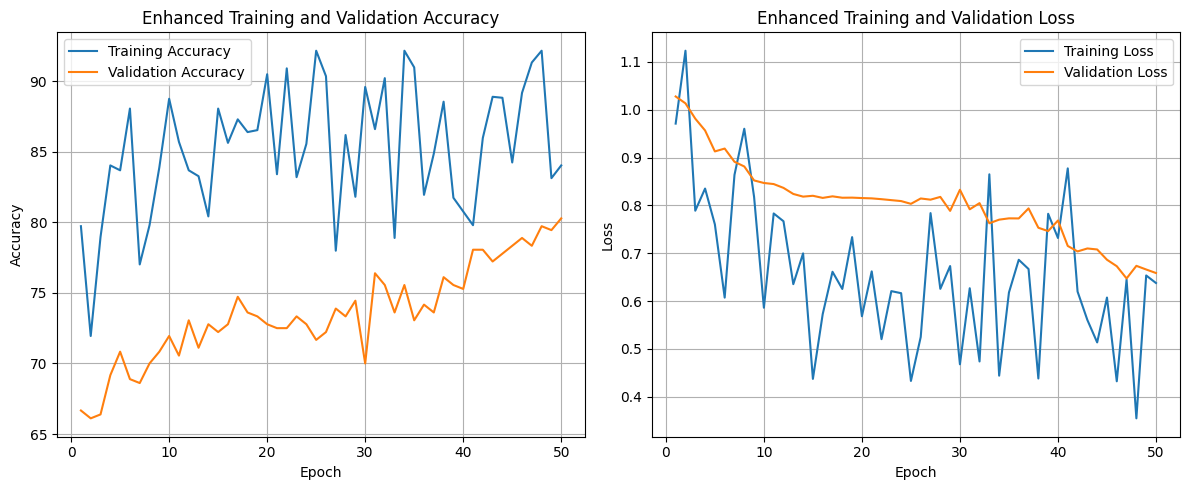

Plots for enhanced training and validation accuracy and loss generated.


In [28]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Enhanced Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Subplot 2: Training and Validation Loss
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Enhanced Training and Validation Loss')
plt.legend()
plt.grid(True)

# Ensure proper spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

print("Plots for enhanced training and validation accuracy and loss generated.")

In [29]:
import torch

# Define the path where the model will be saved
model_save_path = "enhanced_vit_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to enhanced_vit_model.pth


In [31]:
from google.colab import drive
import os
import shutil

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the destination path in Google Drive
drive_path = '/content/drive/MyDrive/face_identification_model'

# Create the directory in Drive if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# 3. Define the source path of the locally saved model
model_save_path = "enhanced_vit_model.pth"

# 4. Copy the model to Google Drive
destination_file_path = os.path.join(drive_path, model_save_path)
shutil.copy(model_save_path, destination_file_path)

print(f"Model '{model_save_path}' successfully copied to Google Drive at '{destination_file_path}'")

Mounted at /content/drive
Model 'enhanced_vit_model.pth' successfully copied to Google Drive at '/content/drive/MyDrive/face_identification_model/enhanced_vit_model.pth'
